In [1]:
from tqdm import tqdm

from lib import mut, plot

from lib.dataloader import load_data
from lib.task import make_tasks

from lib.solver.anneal_solver import AnnealSolver
from lib.temperature import exponential

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = load_data('../all')

big_data = sorted([df for df in data.values() if len(df['trace']) >= 200], key=lambda df: len(df['trace']))
big_tasks = make_tasks(big_data)
top10 = big_tasks[-10:]

In [4]:
init = mut.initializer(mut.GreedyMakeBusyAll())

small = mut.randomize(mut.Flip(),
                      mut.MakeIdle(),
                      mut.GreedyMakeBusy(candidate_retries=50),
                      mut.RandomMakeBusy(candidate_retries=50))

lns_period = 100
is_lns_epoch_predicat = lambda epoch: epoch % lns_period == 0
lns = mut.concat(mut.MakeRoomForRandomCandidate,
                 mut.MakeRoomForRandomCandidate,
                 mut.MakeRoomForRandomCandidate,
                 mut.GreedyMakeBusyAll(),
                 mut.FlippityFlop(limit=50))

mutation = mut.concat(init, mut.conditional(lns, small, epoch_predicat=is_lns_epoch_predicat))

solver = AnnealSolver(
    mutation=mutation,
    epoches=10_000,
    temp=exponential(10000, 1.0005),
    beamsearch_size=2,
)

In [5]:
solver.solve_all(*top10, retries=10, tqdm=tqdm)

100%|██████████| 100/100 [06:48<00:00,  4.08s/it]


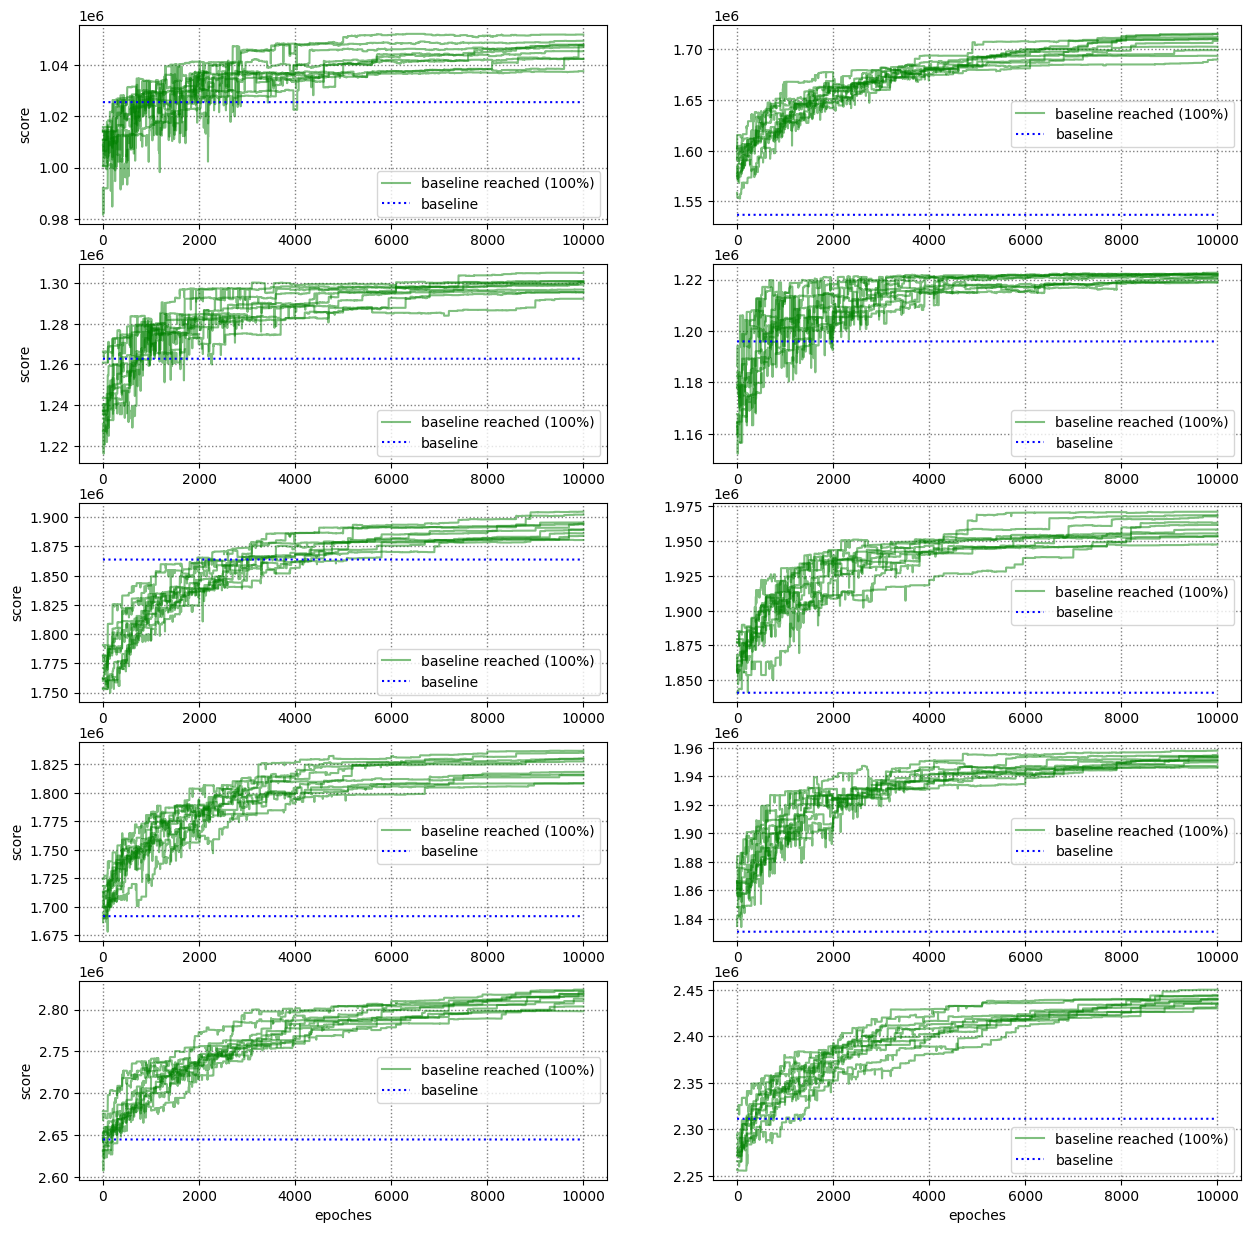

In [6]:
plot.solve_history(*top10, exclude_init=True)

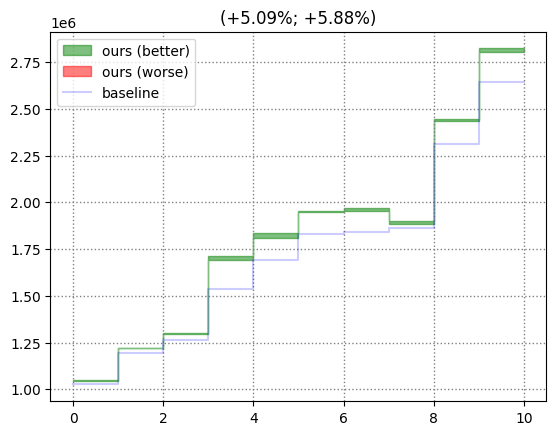

In [7]:
plot.total_diff_interval(*top10, confidence_interval=(0.1, 0.9))

In [8]:
solver.solve_all(*big_tasks, tqdm=tqdm)

100%|██████████| 997/997 [49:52<00:00,  3.00s/it]


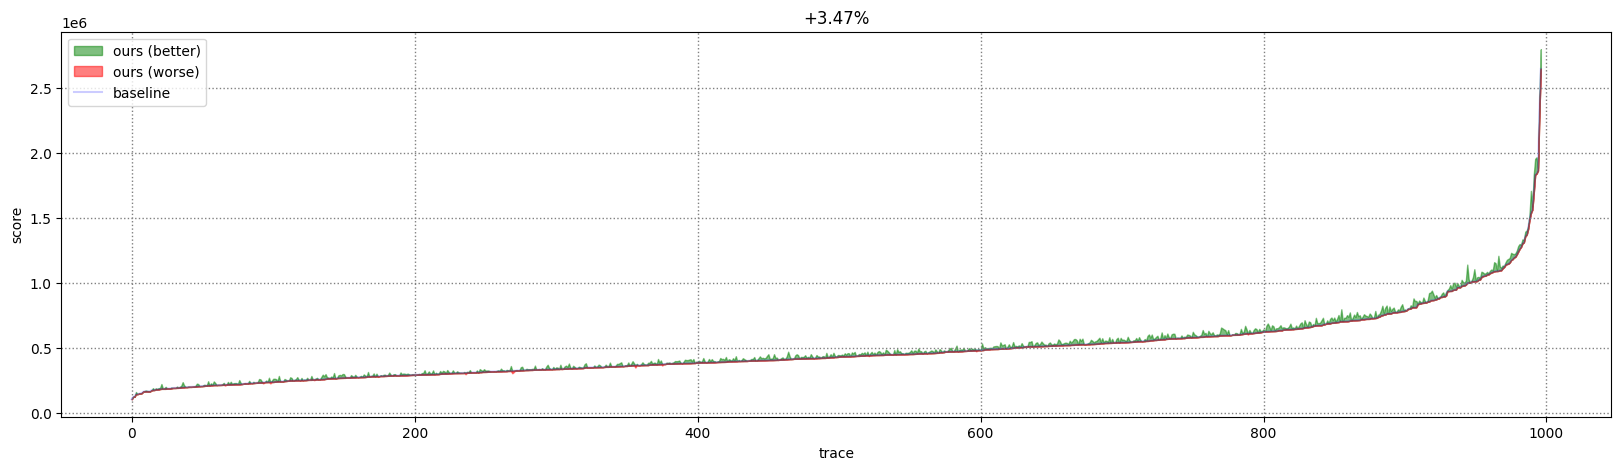

In [9]:
plot.total_diff(*big_tasks, last_n=1, figsize=(20, 5))

In [10]:
%prun -s cumulative solver.solve(big_tasks[0])

         9944868 function calls (8759838 primitive calls) in 3.427 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.431    3.431 {built-in method builtins.exec}
        1    0.007    0.007    3.431    3.431 <string>:1(<module>)
        1    0.005    0.005    3.425    3.425 anneal_solver.py:24(solve)
        1    0.030    0.030    3.413    3.413 anneal.py:86(anneal_beamsearch)
    15618    0.019    0.000    3.140    0.000 anneal.py:100(<listcomp>)
    31236    0.044    0.000    3.121    0.000 anneal.py:30(iterate_anneal)
    31236    0.009    0.000    2.934    0.000 anneal.py:100(<lambda>)
    31236    0.021    0.000    2.926    0.000 anneal_solver.py:28(mutate)
62472/31236    0.037    0.000    2.829    0.000 combine.py:41(impl)
62472/31236    0.046    0.000    2.809    0.000 combine.py:42(<listcomp>)
    62472    0.036    0.000    2.791    0.000 combine.py:17(impl)
    30930    0.035    0.0

In [11]:
%prun -s cumulative solver.solve(big_tasks[-1])

         35883020 function calls (29982508 primitive calls) in 10.392 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   10.396   10.396 {built-in method builtins.exec}
        1    0.008    0.008   10.396   10.396 <string>:1(<module>)
        1    0.005    0.005   10.389   10.389 anneal_solver.py:24(solve)
        1    0.034    0.034   10.376   10.376 anneal.py:86(anneal_beamsearch)
    16232    0.021    0.000   10.071    0.001 anneal.py:100(<listcomp>)
    32464    0.049    0.000   10.050    0.000 anneal.py:30(iterate_anneal)
    32464    0.010    0.000    9.845    0.000 anneal.py:100(<lambda>)
    32464    0.024    0.000    9.835    0.000 anneal_solver.py:28(mutate)
64928/32464    0.040    0.000    9.726    0.000 combine.py:41(impl)
64928/32464    0.052    0.000    9.704    0.000 combine.py:42(<listcomp>)
    64928    0.039    0.000    9.685    0.000 combine.py:17(impl)
    32150    0.040    